Tutorial 1: Models
==================

At the heart of model-fitting is the model: a set of equations, numerical processes, and assumptions describing a
physical system of interest. The goal of model-fitting is to better understand this physical system and develop
predictive models that describe it more accurately.

In astronomy, a model might describe the distribution of stars within a galaxy. In biology, it might represent the
interaction of proteins within a cell. In finance, it could describe the evolution of stock prices in a market.
Regardless of the field, the model acts as a mathematical description of the physical system, aiming to enhance
understanding and enable new predictions.

Whatever your model, its equations are defined by "free parameters." Changing these parameters alters the
behavior and predictions of the model.

Once the model is defined and parameter values are chosen, the model creates "model data"—a realization of how the
physical system appears given those parameters. This process, often referred to as "forward modeling," describes the
physical system from its starting point and predicts the data we observe.

By varying the model parameters, we can generate numerous model datasets. The ultimate goal of model-fitting, which
you will learn by the end of this chapter, is to determine the model parameters and corresponding dataset that best
fit the observed data.

__Astronomy Example__

For instance, in astronomy, we might model the distribution of stars, including:

- A parameter describing the brightness of the stars.

- Multiple parameters defining their distribution.

- Several parameters describing their colors.

If our model pertains to the distribution of stars within a galaxy, the forward model will produce an image of what
that galaxy looks like when observed with a telescope. This forward model might account for physical effects such as
the blurring of light due to diffraction in the telescope optics.

By altering the parameters describing the stars, we can generate many different model images via this forward model.

At the end of this chapter, we will use a real-world astronomy example to illustrate everything you have learned,
including fitting a real galaxy observed with the Hubble Space Telescope.

__Overview__

In tutorial 1, we will cover the basics of defining a model, specifically:

- Defining a simple model described by a few simple equations.

- Showing that this model is characterized by three or more free parameters.

- Using the model, with different sets of parameters, to generate model data.

__Contents__

This tutorial is split into the following sections:

- **Paths**: Setting up the working directory path so the tutorial runs correctly on your computer.
- **PyProjRoot**: A brief introduction to the PyProjRoot package, which sets the working directory for Jupiter notebooks.
- **Model Parameterization**: An example of how a model is parameterized and is made up of free parameters.
- **Model Composition**: Composing a model using PyAutoFit's model composition API.
- **Model Creation**: Creating an instance of the model using PyAutoFit's `Model` python object.
- **Model Mapping**: Mapping an input vector of parameters to the model to create an instance of the model.
- **Complex Models**: Composing a more complex model with multiple model components and more free parameters.
- **Tuple Parameters**: Defining a model component with tuple parameters.
- **Extensibility**: Discussing how PyAutoFit's model composition API is scalable and extensible.
- **Wrap Up**: Concluding the tutorial and considering how to apply the concepts to your own scientific problem.

This tutorial introduces the PyAutoFit API for model composition, which forms the foundation of all model-fitting
performed by PyAutoFit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import autofit as af

__Paths__

PyAutoFit assumes the current working directory is /path/to/autofit_workspace/ on your hard-disk (or in Binder). 
This setup allows PyAutoFit to:

- Load configuration settings from config files in the autofit_workspace/config folder.

- Load example data from the autofit_workspace/dataset folder.

- Output the results of model fits to your hard disk in the autofit/output folder.

If you don't have an autofit_workspace, you can download it here:
 
 https://github.com/Jammy2211/autofit_workspace

__PyProjRoot__

At the top of every tutorial notebook, you will see the following cell. This cell uses the project pyprojroot to 
locate the path to the workspace on your computer and set it as the working directory of the notebook.

In [2]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

/mnt/c/Users/Jammy/Code/PyAuto/stfc_data_summer_school_2024_2
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/stfc_data_summer_school_2024_2`


__Model Parameterization__

A model is a set of equations, numerical processes, and assumptions that describe a physical system and dataset.

In this example, our model is one or more 1-dimensional Gaussians, defined by the following equation:

\begin{equation*}
g(x, I, \sigma) = \frac{N}{\sigma\sqrt{2\pi}} \exp{(-0.5 (x / \sigma)^2)}
\end{equation*}

Where:

- `x`: The x-axis coordinate where the Gaussian is evaluated.

- `N`: The overall normalization of the Gaussian.


- `\sigma`: The size of the Gaussian (Full Width Half Maximum, $\mathrm{FWHM}$, is $2{\sqrt{2\ln 2}}\;\sigma$).

While a 1D Gaussian might seem like a rudimentary model, it has many real-world applications in signal processing. 
For example, 1D Gaussians are fitted to datasets to measure the size of an observed signal. Thus, this model has 
practical real-world applications.

We now have a model, expressed as a simple 1D Gaussian. The model has three parameters, $(x, N, \sigma)$. Using 
different combinations of these parameters creates different realizations of the model, which we illustrate below.

__Model Composition__

We now define the 1D Gaussian as a "model component" in PyAutoFit. We use the term "model component" because the model 
can be extended to include multiple components, each related to different equations and numerical processes. 

We first illustrate a model composed of a single model component, the 1D Gaussian. We then show a model made of
multiple model components.

To define a "model component" in PyAutoFit, we simply write it as a Python class using the format shown below:

In [3]:


class Gaussian:
    def __init__(
        self,
        centre: float = 30.0,  # <- **PyAutoFit** recognises these constructor arguments
        normalization: float = 1.0,  # <- are the Gaussian`s model parameters.
        sigma: float = 5.0,
    ):
        """
        Represents a 1D Gaussian profile.

        This is a model-component of example models in the **HowToFit** lectures and is used to perform model-fitting
        of example datasets.

        Parameters
        ----------
        centre
            The x coordinate of the profile centre.
        normalization
            Overall normalization of the profile.
        sigma
            The sigma value controlling the size of the Gaussian.
        """
        self.centre = centre
        self.normalization = normalization
        self.sigma = sigma

    def model_data_from(self, xvalues: np.ndarray) -> np.ndarray:
        """
        Returns a 1D Gaussian on an input list of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the Gaussian, via its `centre`.

        The output is referred to as the `model_data` to signify that it is a representation of the data from the
        model.

        Parameters
        ----------
        xvalues
            The x coordinates in the original reference frame of the data.

        Returns
        -------
        np.array
            The Gaussian values at the input x coordinates.
        """
        transformed_xvalues = np.subtract(xvalues, self.centre)
        return np.multiply(
            np.divide(self.normalization, self.sigma * np.sqrt(2.0 * np.pi)),
            np.exp(-0.5 * np.square(np.divide(transformed_xvalues, self.sigma))),
        )


The format of this Python class defines how PyAutoFit composes the Gaussian as a model component, where:

- The name of the class is the name of the model component, in this case, "Gaussian".

- The input arguments of the constructor (the `__init__` method) are the parameters of the model, in the example 
above `centre`, `normalization`, and `sigma`.

- The default values and typing of the input arguments define whether a parameter is a single-valued float or a 
multi-valued tuple. For the `Gaussian` class above, no input parameters are tuples, but later examples use tuples.

- It includes functions associated with that model component, specifically the model_data function. When we create 
instances of a `Gaussian` below, this function is used to generate a 1D representation of it as a NumPy array.

__Model Creation__

The `Gaussian` class above is a standard Python class. It does not yet act as a model component that can be used
for model fitting with PyAutoFit.

To transform the Gaussian class into a model component that can be used for model fitting with PyAutoFit, we use 
the `af.Model` object. This tells PyAutoFit to treat the input Python class as a model component.

In [4]:
model = af.Model(Gaussian)
print("Model `Gaussian` object: \n")
print(model)

Model `Gaussian` object: 

Gaussian (centre, UniformPrior [0], lower_limit = 0.0, upper_limit = 100.0), (normalization, LogUniformPrior [1], lower_limit = 1e-06, upper_limit = 1000000.0), (sigma, UniformPrior [2], lower_limit = 0.0, upper_limit = 25.0)


In PyAutoFit, a Model object encapsulates a model component that can be used for model fitting. It provides several 
attributes that describe the model component, such as the `total_free_parameters` attribute, which indicates the 
number of free parameters in the model:

In [5]:
print(model.total_free_parameters)

3


In PyAutoFit, you can retrieve comprehensive information about a model by accessing its `info` attribute.

When you print the model info, it displays detailed information about each parameter in the model, including its name, 
type, and associated prior distribution. Priors define the expected range or distribution of values for each 
parameter during the model fitting process. If you're unfamiliar with priors, they are covered in tutorial 3 of 
this chapter, which explains their role in model fitting.

[The `info` below may not display optimally on your computer screen, for example the whitespace between parameter
names on the left and parameter priors on the right may lead them to appear across multiple lines. This is a
common issue in Jupyter notebooks.

The`info_whitespace_length` parameter in the file `config/general.yaml` in the "output" section can be changed to 
increase or decrease the amount of whitespace (The Jupyter notebook kernel will need to be reset for this change to 
appear in a notebook).]

In [6]:
print(model.info)

Total Free Parameters = 3

model                                                                           Gaussian (N=3)

centre                                                                          UniformPrior [0], lower_limit = 0.0, upper_limit = 100.0
normalization                                                                   LogUniformPrior [1], lower_limit = 1e-06, upper_limit = 1000000.0
sigma                                                                           UniformPrior [2], lower_limit = 0.0, upper_limit = 25.0


__Model Mapping__

In PyAutoFit, instances of model components created via the af.Model object can be instantiated by mapping an input 
vector of parameters to the Python class that the model object represents. The order of parameters in the model is 
crucial for correctly defining the input vector.

To determine the order of parameters in the model, PyAutoFit provides the paths attribute of the model object. 
This attribute contains information about the parameter paths within the model.

Here's how you can access the paths attribute to understand the order of parameters in the model:

In [7]:
print(model.paths)

[('centre',), ('normalization',), ('sigma',)]


To create an instance of the Gaussian model component using PyAutoFit, following the order of parameters defined by 
the paths attribute (`centre`, `normalization`, and `sigma`), you can initialize the instance as follows:

In [8]:
instance = model.instance_from_vector(vector=[30.0, 2.0, 3.0])

This is an instance of the `Gaussian` class.

In [9]:
print("Model Instance: \n")
print(instance)

Model Instance: 



It has the parameters of the `Gaussian` with the values input above.

In [10]:
print("Instance Parameters \n")
print("x = ", instance.centre)
print("normalization = ", instance.normalization)
print("sigma = ", instance.sigma)

Instance Parameters 

x =  30.0
normalization =  2.0
sigma =  3.0


We can use all class functions, such as the `model_data_from` function, to generate an instance of the 
1D `Gaussian` and visualize it through plotting.

The code below generates the 1D Gaussian model data, which requires an input list of x values where the Gaussian is
evaluated. The output is a NumPy array of the Gaussian's y values at the input x coordinates.

Although simple, the code below is essentially the process of forward modeling, where we use the model to generate
the data we would observe in an experiment for a given set of parameters.

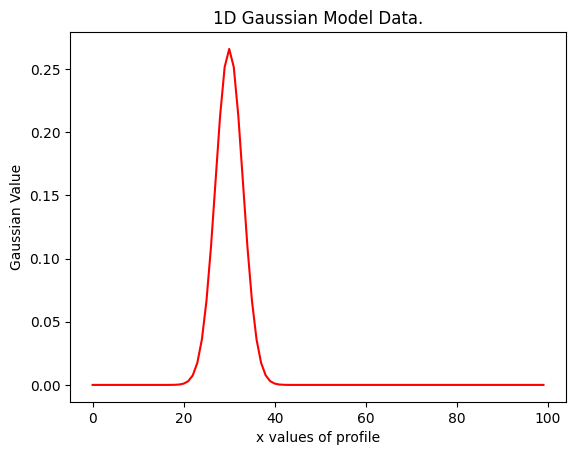

<Figure size 640x480 with 0 Axes>

In [11]:
xvalues = np.arange(0.0, 100.0, 1.0)

model_data = instance.model_data_from(xvalues=xvalues)

plt.plot(xvalues, model_data, color="r")
plt.title("1D Gaussian Model Data.")
plt.xlabel("x values of profile")
plt.ylabel("Gaussian Value")
plt.show()
plt.clf()

__Complex Models__

The code above may seem like a lot of steps just to create an instance of the `Gaussian` class. Couldn't we have 
simply done this instead?

```python
instance = Gaussian(centre=30.0, normalization=2.0, sigma=3.0)
```

Yes, we could have.

However, the model composition API used above is designed to simplify the process of composing complex models that 
consist of multiple components with many free parameters. It provides a scalable approach for defining and 
manipulating models.

To demonstrate this capability, let's conclude the tutorial by composing a model composed of a Gaussian 
component and another 1D profile, an `Exponential`, defined by the equation:

\begin{equation*}
g(x, I, \lambda) = N \lambda \exp{- \lambda x }
\end{equation*}

where:

- `x`: Represents the x-axis coordinate where the Exponential profile is evaluated.

- `N`: Describes the overall normalization of the Exponential profile.

- $\lambda$: Represents the rate of decay of the exponential.

We'll start by defining the `Exponential` profile using a format similar to the Gaussian definition above.

In [12]:


class Exponential:
    def __init__(
        self,
        centre: float = 30.0,  # <- **PyAutoFit** recognises these constructor arguments
        normalization: float = 1.0,  # <- are the Exponential`s model parameters.
        rate: float = 0.01,
    ):
        """
        Represents a 1D Exponential profile.

        This is a model-component of example models in the **HowToFit** lectures and is used to fit example datasets
        via a non-linear search.

        Parameters
        ----------
        centre
            The x coordinate of the profile centre.
        normalization
            Overall normalization of the profile.
        ratw
            The decay rate controlling has fast the Exponential declines.
        """
        self.centre = centre
        self.normalization = normalization
        self.rate = rate

    def model_data_from(self, xvalues: np.ndarray):
        """
        Returns a 1D Gaussian on an input list of Cartesian x coordinates.

        The input xvalues are translated to a coordinate system centred on the `Exponential`, via its `centre`.

        The output is referred to as the `model_data` to signify that it is a representation of the data from the
        model.

        Parameters
        ----------
        xvalues
            The x coordinates in the original reference frame of the data.
        """
        transformed_xvalues = np.subtract(xvalues, self.centre)
        return self.normalization * np.multiply(
            self.rate, np.exp(-1.0 * self.rate * abs(transformed_xvalues))
        )


We can construct a model comprising one `Gaussian` object and one `Exponential` object using the `af.Collection` object:

In [13]:
model = af.Collection(gaussian=af.Model(Gaussian), exponential=af.Model(Exponential))

You can retrieve all the information about the model created via the `af.Collection` by printing its `info` attribute 
in one go:

In [14]:
print(model.info)

Total Free Parameters = 6

model                                                                           Collection (N=6)
    gaussian                                                                    Gaussian (N=3)
    exponential                                                                 Exponential (N=3)

gaussian
    centre                                                                      UniformPrior [3], lower_limit = 0.0, upper_limit = 100.0
    normalization                                                               LogUniformPrior [4], lower_limit = 1e-06, upper_limit = 1000000.0
    sigma                                                                       UniformPrior [5], lower_limit = 0.0, upper_limit = 25.0
exponential
    centre                                                                      UniformPrior [6], lower_limit = 0.0, upper_limit = 100.0
    normalization                                                               LogUniformPrior [7], lowe

When `Gaussian` and `Exponential` are added to a `Collection`, they are automatically assigned as `Model` objects.

Therefore, there's no need to use the `af.Model` method when passing classes to a `Collection`, which makes the Python 
code more concise and readable.

In [15]:
model = af.Collection(gaussian=Gaussian, exponential=Exponential)

The `model.info` is identical to the previous example.

In [16]:
print(model.info)

Total Free Parameters = 6

model                                                                           Collection (N=6)
    gaussian                                                                    Gaussian (N=3)
    exponential                                                                 Exponential (N=3)

gaussian
    centre                                                                      UniformPrior [9], lower_limit = 0.0, upper_limit = 100.0
    normalization                                                               LogUniformPrior [10], lower_limit = 1e-06, upper_limit = 1000000.0
    sigma                                                                       UniformPrior [11], lower_limit = 0.0, upper_limit = 25.0
exponential
    centre                                                                      UniformPrior [12], lower_limit = 0.0, upper_limit = 100.0
    normalization                                                               LogUniformPrior [13], 

A `Collection` functions analogously to a `Model`, but it includes multiple model components.

This can be observed by examining its `paths` attribute, which displays paths to all 6 free parameters across both model components.

The paths contain entries such as `.gaussian.` and `.exponential.`, corresponding to the names we provided when 
defining the `af.Collection` earlier. Modifying the names of the model components supplied to the `Collection` 
would adjust the paths accordingly.

In [17]:
print(model.paths)

[('gaussian', 'centre'), ('gaussian', 'normalization'), ('gaussian', 'sigma'), ('exponential', 'centre'), ('exponential', 'normalization'), ('exponential', 'rate')]


A model instance can again be created by mapping an input `vector`, which now has 6 entries.

In [18]:
instance = model.instance_from_vector(vector=[0.1, 0.2, 0.3, 0.4, 0.5, 0.01])

This `instance` contains each of the model components we defined above. 

The argument names input into the `Collection` define the attribute names of the `instance`:

In [19]:
print("Instance Parameters \n")
print("x (Gaussian) = ", instance.gaussian.centre)
print("normalization (Gaussian) = ", instance.gaussian.normalization)
print("sigma (Gaussian) = ", instance.gaussian.sigma)
print("x (Exponential) = ", instance.exponential.centre)
print("normalization (Exponential) = ", instance.exponential.normalization)
print("sigma (Exponential) = ", instance.exponential.rate)

Instance Parameters 

x (Gaussian) =  0.1
normalization (Gaussian) =  0.2
sigma (Gaussian) =  0.3
x (Exponential) =  0.4
normalization (Exponential) =  0.5
sigma (Exponential) =  0.01


In the context of the model's equations, it is simply the sum of the equations defining the `Gaussian` 
and `Exponential` components.

To generate the `model_data`, we sum the `model_data` of each individual model component, as demonstrated and 
visualized below.

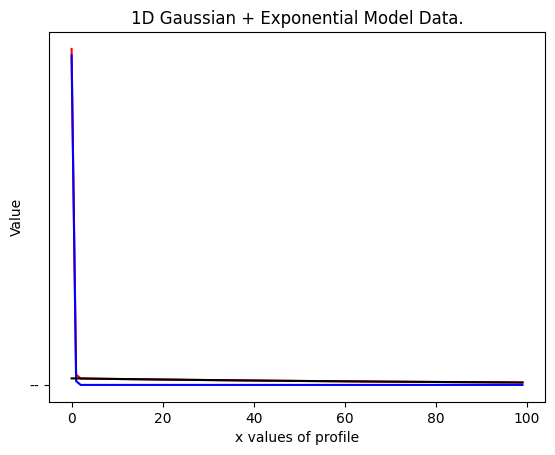

<Figure size 640x480 with 0 Axes>

In [20]:
xvalues = np.arange(0.0, 100.0, 1.0)

model_data_0 = instance.gaussian.model_data_from(xvalues=xvalues)
model_data_1 = instance.exponential.model_data_from(xvalues=xvalues)

model_data = model_data_0 + model_data_1

plt.plot(xvalues, model_data, color="r")
plt.plot(xvalues, model_data_0, "b", "--")
plt.plot(xvalues, model_data_1, "k", "--")
plt.title("1D Gaussian + Exponential Model Data.")
plt.xlabel("x values of profile")
plt.ylabel("Value")
plt.show()
plt.clf()

__Tuple Parameters__

The `Gaussian` and `Exponential` model components above only has parameters that are single-valued floats. 

Parameters can also be tuples, which is useful for defining model components where certain parameters are naturally
grouped together.

For example, we can define a 2D Gaussian with a center that has two coordinates and therefore free parameters, (x, y), 
using a tuple.

In [21]:
from typing import Tuple


class Gaussian2D:
    def __init__(
        self,
        centre: Tuple[float, float] = (0.0, 0.0),
        normalization: float = 0.1,
        sigma: float = 1.0,
    ):
        self.centre = centre
        self.normalization = normalization
        self.sigma = sigma


The model's `total_free_parameters` attribute now includes 4 free parameters, as the tuple `centre` parameter accounts
for 2 free parameters.

In [22]:
model = af.Model(Gaussian2D)

print("Total Free Parameters:", model.total_free_parameters)

Total Free Parameters: 4


This information is again displayed in the `info` attribute:

In [23]:
print("\nInfo:")
print(model.info)


Info:
Total Free Parameters = 4

model                                                                           Gaussian2D (N=4)

centre
    centre_0                                                                    UniformPrior [15], lower_limit = 0.0, upper_limit = 100.0
    centre_1                                                                    UniformPrior [16], lower_limit = 0.0, upper_limit = 100.0
normalization                                                                   LogUniformPrior [17], lower_limit = 1e-06, upper_limit = 1000000.0
sigma                                                                           UniformPrior [18], lower_limit = 0.0, upper_limit = 25.0


The `paths` attribute provides information on the order of parameters in the model, illustrating how the
`centre` tuple is split into two parameters.

In [24]:
print("\nPaths:")
print(model.paths)


Paths:
[('centre', 'centre_0'), ('centre', 'centre_1'), ('normalization',), ('sigma',)]


This ordering is used to create an instance of the `Gaussian2D` model component:

In [25]:
instance = model.instance_from_vector(vector=[40.0, 60.0, 2.0, 3.0])

print("\nInstance Parameters:")
print("centre (x) = ", instance.centre[0])
print("centre (y) = ", instance.centre[1])
print("normalization = ", instance.normalization)
print("sigma = ", instance.sigma)


Instance Parameters:
centre (x) =  40.0
centre (y) =  60.0
normalization =  2.0
sigma =  3.0


__Extensibility__

It should now be clear why we use `Model` and `Collection` objects to construct our model.

These objects facilitate the straightforward extension of our models to include multiple components and parameters. 
For instance, we can add more `Gaussian` and `Exponential` components to the `Collection`, or define new Python 
classes to represent entirely new model components with additional parameters.

These objects serve numerous other essential purposes that we will explore in subsequent tutorials.

**PyAutoFit** offers a comprehensive API for building models, which includes models constructed using NumPy arrays, 
hierarchies of Python classes, and graphical models where parameters are interconnected. These advanced modeling 
techniques are gradually introduced throughout the HowToFit lectures.

For a detailed understanding of PyAutoFit's model composition API and a quick reference guide on how to construct 
models, you may want to take a quick look at the model cookbook in the PyAutoFit documentation. It provides an 
extensive overview and can serve as a helpful resource as you progress:

[PyAutoFit Model Cookbook](https://pyautofit.readthedocs.io/en/latest/cookbooks/model.html)

Don't worry if it seems a bit overwhelming at this stage; the concepts will become clearer as you continue exploring 
and working with PyAutoFit.

__Wrap Up__

In this tutorial, we've learned how to define and compose a model that can generate model data.

Now, think about your specific field of study and the problem you want to address through model-fitting. Consider 
the following questions:

- What type of model would best describe your data?

- Which Python class, following the format introduced here, would you need to compose this model?

- What are the free parameters of your model that need to be determined through fitting?

If you decide to incorporate a new model component into your autofit_workspace tailored to your specific model-fitting 
task, refer to the following script:

autofit_workspace/*/overview/new_model_component/new_model_component.ipynb

This script provides guidance on setting up the PyAutoFit configuration files associated with your custom model.